In [1]:
!pip install -e ../src/

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/kitamura/work/DeepLearning/mlops/src
  Attempting uninstall: mlops
    Found existing installation: mlops -.-.-
    Uninstalling mlops--.-.-:
      Successfully uninstalled mlops--.-.-
  Running setup.py develop for mlops


In [1]:
import os
import glob

import numpy as np
import cv2
import matplotlib.pyplot as plt
from hydra.experimental import initialize, compose
from tqdm import tqdm

import mlops
import mython

In [2]:
data_dir = os.path.join(os.environ["HOME"], "dataset", "NEUMetalSurfaceDefects", "train")

result_dir = "../experiments/test_v0"
with initialize(config_path=result_dir):
    cfg = compose(config_name="config.yaml")

gen = mlops.dataset.TrainDataGenerator(cfg["dataset"])
train_ds = mython.debug.run_debug(
    lambda: gen.create_dataset()
)

In [3]:
import cProfile

def test_loop():
    #for idx, (imgs, labels) in tqdm(enumerate(train_ds)):
    for idx, (imgs, labels) in tqdm(enumerate(gen())):
        if idx > 100:
            break
    #indices, cnts = np.unique(labels.numpy().astype(int), return_counts=True)
    #counts[indices] += cnts
    
cProfile.run("test_loop()", "restats")

101it [00:02, 46.43it/s]


In [4]:
imgs, labels = next(gen())
print(imgs.shape)
np.unique(labels.astype(int), return_counts=True)

(120, 24, 24, 3)


(array([1, 2, 3, 4, 5]), array([ 1, 17, 20, 16, 66]))

In [16]:
imgs.var(axis=(1, 2, 3)).mean()

423.92124058601786

In [5]:
import pstats

p = pstats.Stats("restats")
p.strip_dirs().sort_stats('cumulative').print_stats()

Sun Nov 15 12:51:36 2020    restats

         909290 function calls (881579 primitive calls) in 7.483 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.483    7.483 {built-in method builtins.exec}
        1    0.000    0.000    7.483    7.483 <string>:1(<module>)
        1    0.000    0.000    7.483    7.483 <ipython-input-4-ab25603ee1fd>:3(test_loop)
      103    0.001    0.000    7.480    0.073 std.py:1140(__iter__)
      102    0.014    0.000    7.465    0.073 dataset.py:191(__call__)
     6120    0.007    0.000    6.677    0.001 pool.py:637(get)
     6147    0.011    0.000    6.672    0.001 threading.py:533(wait)
     6120    0.004    0.000    6.665    0.001 pool.py:634(wait)
     2542    0.010    0.000    6.654    0.003 threading.py:263(wait)
    17861    6.640    0.000    6.640    0.000 {method 'acquire' of '_thread.lock' objects}
      102    0.010    0.000    5.964    0.058 dataset.p

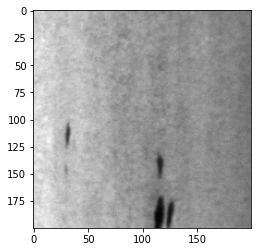

In [4]:
data_dir = os.path.join(os.environ["HOME"], "dataset", "NEUMetalSurfaceDefects", "train")
#filename = os.path.join(data_dir, "Crazing", "Cr_2.bmp")
filename = os.path.join(data_dir, "1_Inclusion", "In_2.bmp")
img = cv2.imread(filename, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
#plt.imshow(img[:, :, ::-1])
plt.imshow(img, cmap="gray")

def create_4k_image(filename, output_dir=os.path.join(data_dir, "0_Crazing_4k")):
    img = cv2.imread(filename)
    output = np.zeros((4096, 4096, 3), dtype=np.uint8)
    for top in range(1000, 3000, img.shape[0]):
        for left in range(1000, 3000, img.shape[1]):
            output[top:top + img.shape[0], left: left + img.shape[1]] = img
            
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_fname = os.path.join(output_dir, "{}.png".format(os.path.basename(filename).split(".")[0]))
    cv2.imwrite(output_fname, img)
    print("save to {} : {}".format(output_dir, output_fname))

In [9]:
img.shape

(200, 200, 3)

In [40]:
for fname in glob.glob(os.path.join(data_dir, "0_Crazing", "*.bmp")):
    create_4k_image(fname)

save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_51.png
save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_94.png
save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_284.png
save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_2.png
save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_81.png
save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_129.png
save to /home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k : /home/kitamura/dataset/N

In [1]:
import mlops

num_crop = 66
filename = "/home/kitamura/dataset/NEUMetalSurfaceDefects/train/0_Crazing_4k/Cr_51.png"
output_image_size = 24
num_channel = 3
edge_ratio = 0.5
max_thresh = 100
var_thresh = 270

res = mlops.dataset._augment_and_crop_flawless_images(
    num_crop, filename, output_image_size, num_channel, edge_ratio=edge_ratio, max_thresh=max_thresh, variance_thresh=var_thresh)